In [1]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import sys
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/mnist/input_data.py
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # haha
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [20]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, 
                 batch_size=100, 
                 train_keep_prob=1.0, 
                 warmup=False, 
                 batch_norm = True,
                iw=False):
        
        
        
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.importance_weighting = iw
        
        self.warmup = warmup
        self.batch_norm = batch_norm
        self.train_keep_prob = train_keep_prob
        
        self.epoch = 0.
        self.beta = 1.
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Keep Probability
        self.keep_prob = tf.placeholder(tf.float32)
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        #self._create_loss_optimizer()
        
        self.optimizer = tf.train.AdamOptimizer(1e-4).minimize(-self._evidence_lower_bound(\
                    importance_weighting=self.importance_weighting))
        
        self.cost = -self._evidence_lower_bound(\
                    importance_weighting=self.importance_weighting)

        
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        self.network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(self.x,self.network_weights["weights_recog"], 
                                      self.network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

#         # Use generator to determine mean of
#         # Bernoulli distribution of reconstructed input
#         self.x_reconstr_mean = \
#             self._generator_network(network_weights["weights_gener"],
#                                     network_weights["biases_gener"])
            
            # Use generator to determine mean and (log) variance of
        # Gaussian distribution of reconstructed input
        self.x_reconstr_mean, self.x_reconstr_log_sigma_sq = \
            self._generator_network(self.z,self.network_weights["weights_gener"],
                                   self.network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, x, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(x, weights['h1']), 
                                           biases['b1'])) 
        layer_1 = tf.nn.dropout(layer_1, self.keep_prob)
        
        if self.batch_norm:
            mom_mean1, mom_var1 = tf.nn.moments(layer_1, [0])
            layer_1 = tf.nn.batch_normalization(layer_1,mom_mean1,mom_var1,None,None,1E-5)

        
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        
        layer_2 = tf.nn.dropout(layer_2, self.keep_prob)
        
        if self.batch_norm:
            mom_mean2, mom_var2 = tf.nn.moments(layer_2, [0])
            layer_2 = tf.nn.batch_normalization(layer_2,mom_mean2,mom_var2,None,None,1E-5)
        
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']),
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, z, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(z, weights['h1']), 
                                           biases['b1'])) 
        
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        x_reconstr_log_sigma_sq = \
            0.5*tf.nn.tanh(tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                                  biases['out_log_sigma']))
            
        return (x_reconstr_mean, x_reconstr_log_sigma_sq)
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.\n",
        # Adding 1e-10 to avoid evaluatio of log(0.0)\n",
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
            + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
            1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence
        #    between the distribution in latent space induced by the encoder on
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(self.beta * (1 + self.z_log_sigma_sq
            - tf.square(self.z_mean)
            - tf.exp(self.z_log_sigma_sq)), 1)
#         elif self.gen_distribution == 'gaussian':
#             #RECONSTRUCTION LOSS GAUSSIAN
#             reconstr_loss = \
#                 -tf.reduce_sum(-(0.5 * np.log(2 * np.pi)
#                 + self.x_reconstr_log_sigma_sq)
#                 - 0.5 * tf.square((self.x - self.x_reconstr_mean)
#                 / tf.exp(self.x_reconstr_log_sigma_sq)),
#                 1)
#             #LATENT LOSS GAUSSIAN
#             latent_loss = -0.5 * tf.reduce_sum(1 + 2*self.z_log_sigma_sq
#                 - tf.square(self.z_mean)
#                 - tf.exp(2*self.z_log_sigma_sq), 1)
        # average over batch
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
    
    def _evidence_lower_bound(self,
                              monte_carlo_samples=5,
                              importance_weighting=False,
                              tol=1e-5):
        """
            Variational objective function
            ELBO = E(log joint log-likelihood) - E(log q)
                 = MC estimate of log joint - Entropy(q)
        """


        x_resampled = tf.tile(self.x, tf.constant([monte_carlo_samples, 1]))

        # Forward pass of data into latent space
        mean_encoder, log_variance_encoder = self._recognition_network(x_resampled,self.network_weights["weights_recog"], 
                                      self.network_weights["biases_recog"])

        random_noise = tf.random_normal(
            (self.batch_size * monte_carlo_samples, self.network_architecture['n_z']), 0, 1, dtype=tf.float32)

        # Reparameterization trick of re-scaling/transforming random error
        std_dev = tf.sqrt(tf.exp(log_variance_encoder))
        z = mean_encoder + std_dev * random_noise

        # Reconstruction/decoding of latent space
        mean_decoder, _ = self._generator_network(z,self.network_weights["weights_gener"],
                                   self.network_weights["biases_gener"])

        # Bernoulli log-likelihood reconstruction
        # TODO: other distributon types
        def bernoulli_log_joint(x):
            return tf.reduce_sum(
                (x * tf.log(tol + mean_decoder))
                    + ((1 - x) * tf.log(tol + 1 - mean_decoder)), 
                1)

        log2pi = tf.log(2.0 * np.pi)

        def gaussian_likelihood(data, mean, log_variance):
            """Log-likelihood of data given ~ N(mean, exp(log_variance))

            Parameters
            ----------
            data : 
                Samples from Gaussian centered at mean
            mean : 
                Mean of the Gaussian distribution
            log_variance : 
                Log variance of the Gaussian distribution
            Returns
            -------
            log_likelihood : float
            """

            num_components = data.get_shape().as_list()[1]
            variance = tf.exp(log_variance)
            log_likelihood = (
                -(log2pi * (num_components / 2.0))
                - tf.reduce_sum(
                    (tf.square(data - mean) / (2 * variance)) + (log_variance / 2.0),
                    1)
            )

            return log_likelihood

        def standard_gaussian_likelihood(data):
            """Log-likelihood of data given ~ N(0, 1)
            Parameters
            ----------
            data : 
                Samples from Guassian centered at 0
            Returns
            -------
            log_likelihood : float
            """

            num_components = data.get_shape().as_list()[1]
            log_likelihood = (
                -(log2pi * (num_components / 2.0))
                - tf.reduce_sum(tf.square(data) / 2.0, 1)
            )

            return log_likelihood

        log_p_given_z = bernoulli_log_joint(x_resampled)

        if importance_weighting:
            log_q_z = gaussian_likelihood(z, mean_encoder, log_variance_encoder)
            log_p_z = standard_gaussian_likelihood(z)

            regularization_term = log_p_z - log_q_z
        else:
            # Analytic solution to KL(q_z | p_z)
            p_z_q_z_kl_divergence = \
                -self.beta*0.5 * tf.reduce_sum(1 
                                + log_variance_encoder
                                - tf.square(mean_encoder) 
                                - tf.exp(log_variance_encoder), 1) 

            regularization_term = -p_z_q_z_kl_divergence

        log_p_given_z_mc = tf.reshape(log_p_given_z, 
                                    [self.batch_size, monte_carlo_samples])
        regularization_term_mc = tf.reshape(regularization_term,
                            [self.batch_size, monte_carlo_samples])

        log_weights = log_p_given_z_mc + regularization_term_mc

        if importance_weighting:
            # Need to compute normalization constant for weights, which is
            # log (sum (exp(log_weights)))
            # weights_iw = tf.log(tf.sum(tf.exp(log_weights)))

            # Instead using log-sum-exp trick
            wmax = tf.reduce_max(log_weights, 1, keep_dims=True)

            # w_i = p_x/ q_z, log_wi = log_p_joint - log_qz
            # log ( 1/k * sum(exp(log w_i)))
            weights_iw = tf.log(tf.reduce_mean(tf.exp(log_weights - wmax), 1))
            objective = tf.reduce_mean(wmax) + tf.reduce_mean(weights_iw)
        else:
            objective = tf.reduce_mean(log_weights)

        return objective

    
    
    def partial_fit(self, X, epo):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        self.epoch= epo
        
        if self.warmup:
            #Warm-up Beta
            N_t = 30. #Number of epochs in warmup phase
            self.beta=self.epoch/N_t
        
        
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X, self.keep_prob: self.train_keep_prob})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X, self.keep_prob: 1.0})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu, self.keep_prob: 1.0})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X, self.keep_prob: 1.0})
    
def latent_covar(vae,n_samples=mnist.test.num_examples):
    test_data, _ =mnist.test.next_batch(n_samples)
    z_mean = vae.transform(test_data)
    return np.var(z_mean,0)

def count_significant(vae,threshold=1e-2,n_samples=mnist.test.num_examples):
    return np.greater(latent_covar(vae,n_samples),threshold).sum()

In [25]:
def train(network_architecture, learning_rate=0.001,
            batch_size=100,
            training_epochs=10,
            display_step=1,
            train_keep_prob=1.0,
            batch_norm = True,
            warmup=False,
            iw=False):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size,
                                 train_keep_prob=train_keep_prob,
                                 batch_norm = batch_norm,
                                 warmup=warmup,
                                iw=iw)
    
    cost_list=np.ndarray(shape=(training_epochs,1),dtype=float)
    n_z=network_architecture['n_z']
    covar_list=np.ndarray(shape=(training_epochs,n_z),dtype=float)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs, epoch)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size
            # Active Latent Dimension Count
            count = (count_significant(vae,n_samples=100))
            
        if np.isnan(avg_cost):
            print 'nan'
            nan = epoch
            break
        # Display logs per epoch step
        if epoch % display_step == 0:
            print "Epoch:", '%04d' % (epoch+1), \
                  "cost=", "{:.9f}".format(avg_cost),\
                  "latent count=", "%d" % count
            sys.stdout.flush()
        cost_list.itemset((epoch,0),avg_cost)
        covari=latent_covar(vae,n_samples=100)
        for i in xrange(n_z):
            covar_list.itemset((epoch,i),covari[i])
        nan = epoch    
    return vae, cost_list, covar_list, nan

In [40]:
def run_test(z_dim,keep_prob,b_normal,warmup, iw ,t_epochs=300, trial_num=0):
    network_architecture = \
        dict(n_hidden_recog_1=100, # 1st layer encoder neurons
             n_hidden_recog_2=100, # 2nd layer encoder neurons
             n_hidden_gener_1=100, # 1st layer decoder neurons
             n_hidden_gener_2=100, # 2nd layer decoder neurons
             n_input=784, # MNIST data input (img shape: 28*28)
             n_z=z_dim)  # dimensionality of latent space

    vae, cost_list, covar_list, nan = train(network_architecture,learning_rate=0.001,
                                        batch_size=100,
                                        training_epochs=t_epochs,
                                        display_step=10,
                                        train_keep_prob=keep_prob,
                                        batch_norm = (b_normal==1),
                                        warmup = warmup,
                                        iw=iw)

    namestring='trials_final/{}.{}.{}.{}.{}.trial{}.endedat{}.pkl'.format(z_dim,keep_prob,b_normal,warmup,iw,trial_num,nan)
    pickle.dump({'cost':cost_list,'covar':covar_list},open(namestring,'wb'))
    vae.sess.close()

In [ ]:
for i in range(3):
    print i
    #Vanilla
    print 'VANILLA'
    run_test(50,1.0,0,0,0,trial_num=i+2)
    #IW
    print 'IW' 
    run_test(50,1.0,0,0,1,trial_num=i+2)
    #WU
    print 'WU' 
    run_test(50,1.0,0,1,1,trial_num=i+2)
    
for i in range(3):
    for nz in [2,10,20,100]:
        run_test(nz,1.0,0,0,1,trial_num=i)
        
for i in range(3):
    for keep in [0.6,0.8,0.9]:
        run_test(50,keep,0,0,1,trial_num=i)
        
for i in range(5):
    print 'BN' 
    run_test(50,1.0,1,0,1,trial_num=i+2)
    #BN+WU
    print 'BNWU' 
    run_test(50,1.0,1,1,1,trial_num=i+2)


0
VANILLA
Epoch: 0001 cost= 265.189315380 latent count= 48
Epoch: 0011 cost= 142.914030151 latent count= 50
Epoch: 0021 cost= 125.487213981 latent count= 49
Epoch: 0031 cost= 118.437533292 latent count= 50
Epoch: 0041 cost= 114.825090901 latent count= 46
Epoch: 0051 cost= 112.591779633 latent count= 37
Epoch: 0061 cost= 110.752411693 latent count= 34
Epoch: 0071 cost= 109.897258814 latent count= 28
Epoch: 0081 cost= 108.963531633 latent count= 31
Epoch: 0091 cost= 108.135869474 latent count= 24
Epoch: 0101 cost= 107.473314153 latent count= 26
Epoch: 0111 cost= 106.961104237 latent count= 26
Epoch: 0121 cost= 106.535703291 latent count= 28
Epoch: 0131 cost= 106.105572246 latent count= 24
Epoch: 0141 cost= 105.988517137 latent count= 25
Epoch: 0151 cost= 105.549269326 latent count= 23
Epoch: 0161 cost= 105.117968930 latent count= 23
Epoch: 0171 cost= 105.047884313 latent count= 23
Epoch: 0181 cost= 104.720982666 latent count= 25
Epoch: 0191 cost= 104.474392631 latent count= 24
Epoch: 020

In [ ]:
for i in range(5):
    print i
    #Vanilla
    print 'VANILLA'
    run_test(50,1.0,0,1,1,trial_num=i)

In [21]:
run_test(50,1.0,0,1,1,trial_num=0)

Epoch: 0001 cost= 207.612559690 latent count= 37
Epoch: 0011 cost= 105.542976532 latent count= 50
Epoch: 0021 cost= 94.349551239 latent count= 50
Epoch: 0031 cost= 87.164091270 latent count= 50
Epoch: 0041 cost= 82.547086085 latent count= 50
Epoch: 0051 cost= 79.064451599 latent count= 50
Epoch: 0061 cost= 77.767465376 latent count= 47
Epoch: 0071 cost= 76.413862749 latent count= 48
Epoch: 0081 cost= 75.176812231 latent count= 42
Epoch: 0091 cost= 74.372862646 latent count= 38
Epoch: 0101 cost= 73.988233851 latent count= 35
Epoch: 0111 cost= 73.509260490 latent count= 35
Epoch: 0121 cost= 73.345513715 latent count= 25
Epoch: 0131 cost= 72.751592664 latent count= 21
Epoch: 0141 cost= 72.273427055 latent count= 23
Epoch: 0151 cost= 72.261220259 latent count= 18
Epoch: 0161 cost= 71.838041486 latent count= 14
Epoch: 0171 cost= 72.133169923 latent count= 13
Epoch: 0181 cost= 71.512687052 latent count= 13
Epoch: 0191 cost= 71.357833051 latent count= 13


Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f080708cc10>> ignored


KeyboardInterrupt: 

In [9]:
network_architecture = \
    dict(n_hidden_recog_1=200, # 1st layer encoder neurons
         n_hidden_recog_2=200, # 2nd layer encoder neurons
         n_hidden_gener_1=200, # 1st layer decoder neurons
         n_hidden_gener_2=200, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=50)  # dimensionality of latent space

vae, cost_list, covar_list = train(network_architecture,learning_rate=0.001,
                                    batch_size=100,
                                    training_epochs=1,
                                    display_step=10,
                                    train_keep_prob=1.0,
                                    batch_norm = 0,
                                    warmup = 0,
                                    iw = False)

Epoch: 0001 cost= 238.594773643 latent count= 48


RuntimeError: Attempted to use a closed Session.

In [7]:
run_test(50,0.9,0,0, trial_num=(77777))

# for i in range(5):
#     run_test(50,0.9,0,0, trial_num=(i))
#     run_test(50,0.9,1,0, trial_num=(i))
#     run_test(50,0.9,1,1, trial_num=(i))

Epoch: 0001 cost= 199.594517767 latent count= 47
Epoch: 0011 cost= 116.061458102 latent count= 9
Epoch: 0021 cost= 111.486567480 latent count= 9
Epoch: 0031 cost= 109.708253063 latent count= 9
Epoch: 0041 cost= 108.606147641 latent count= 9
Epoch: 0051 cost= 107.887856501 latent count= 9
Epoch: 0061 cost= 107.359480397 latent count= 9
Epoch: 0071 cost= 106.920686132 latent count= 9
Epoch: 0081 cost= 106.604738506 latent count= 9
Epoch: 0091 cost= 106.291280642 latent count= 9
Epoch: 0101 cost= 106.015755088 latent count= 9
Epoch: 0111 cost= 105.791387801 latent count= 9
Epoch: 0121 cost= 105.613634768 latent count= 9
Epoch: 0131 cost= 105.327047161 latent count= 9
Epoch: 0141 cost= 105.306643080 latent count= 9
Epoch: 0151 cost= 105.104632596 latent count= 9
Epoch: 0161 cost= 104.945250022 latent count= 9
Epoch: 0171 cost= 104.801097273 latent count= 9
Epoch: 0181 cost= 104.717475891 latent count= 9
Epoch: 0191 cost= 104.577905690 latent count= 9
Epoch: 0201 cost= 104.493117648 latent 

KeyboardInterrupt: 

In [ ]:
# for i in range(5):
#     run_test(50,1.0,'gaussian',0,0, trial_num=i)
# for i in range(1):
#     run_test(50,1.0,'bernoulli',0,0, trial_num=i)
for i in range(5):
    run_test(50,0.95,1,0, trial_num=(i))
# for i in range(5):
#     run_test(50,1.0,1,1, trial_num=i)
    
# # #Test dropout rate
# for i in range(5):
#     for keep in [0.9,0.8,0.7,0.6]:
#         run_test(50,keep,1,1,trial_num=i)
#Test N_z
# for i in range(5):
#     for n_z in [2,5,10,20,100]:
#         run_test(n_z,0.9,1,1, trial_num=i)
# #Test warmup over dimensions
# for dim in [5,20,50,100]:
#     run_test(dim,1.0,'bernoulli',1,0, trial_num=i)
#     run_test(dim,1.0,'bernoulli',1,1, trial_num=i)
# #Test batch norm over dimensions
# for dim in [5,20,50,100]:
#     run_test(dim,1.0,'bernoulli',0,1, trial_num=i)
#     run_test(dim,1.0,'bernoulli',1,1, trial_num=i)

In [ ]:
run_test(50,1.0,1,0, trial_num=99)

In [ ]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

<matplotlib.colorbar.Colorbar instance at 0x7f2e1032a4d0>

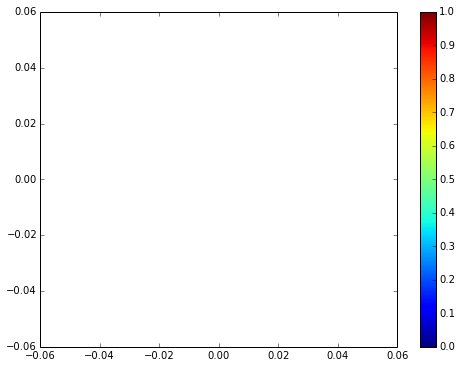

In [33]:

x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
# plt.savefig('vis1.png',dpi=300)

In [34]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])
        x_mean = vae.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()
# plt.savefig('vis2.png',dpi=300)
 

ValueError: Cannot feed value of shape (1, 2) for Tensor u'Add_4:0', which has shape '(100, 50)'

In [ ]:
run_test(50,1.0,'bernoulli',0,0, trial_num=0)

In [ ]:
run_test(50,1.0,'bernoulli',0,0)

In [ ]:
for i in range(5):
    #Initial tests to demonstrate features
    run_test(50,1.0,'gaussian',0,0, trial_num=i)
    run_test(50,1.0,'bernoulli',0,0, trial_num=i)
    run_test(50,1.0,'bernoulli',1,0, trial_num=i)
    run_test(50,1.0,'bernoulli',1,1, trial_num=i)
    #Test dropout rate
    for keep in [1.0,0.9,0.8,0.7,0.6]:
        run_test(50,keep,'bernoulli',1,1, trial_num=i)
    #Test N_z
    for n_z in [2,5,10,20,50,100]:
        run_test(n_z,1.0,'bernoulli',1,1, trial_num=i)
    #Test warmup over dimensions
    for dim in [5,20,50,100]:
        run_test(dim,1.0,'bernoulli',1,0, trial_num=i)
        run_test(dim,1.0,'bernoulli',1,1, trial_num=i)
    #Test batch norm over dimensions
    for dim in [5,20,50,100]:
        run_test(dim,1.0,'bernoulli',0,1, trial_num=i)
        run_test(dim,1.0,'bernoulli',1,1, trial_num=i)

In [ ]:
run_test(50,0.5,'bernoulli',0,0)

In [ ]:
run_test(50,1,'bernoulli',1,0)

In [ ]:
run_test(50,1,'bernoulli',1,1)

In [ ]:
run_test(50,1,'bernoulli',0,1)